In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import SVG, display

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from megabouts.tracking_data.tracking_data import TrackingConfig
from megabouts.tracking_data.load_example import load_example_data
from megabouts.tracking_data.tracking_data import FullTrackingData

from megabouts.preprocessing.tail_preprocessing import TailPreprocessingConfig
from megabouts.preprocessing.tail_preprocessing import TailPreprocessingResult
from megabouts.preprocessing.tail_preprocessing import TailPreprocessing

from megabouts.preprocessing.traj_preprocessing import TrajPreprocessingConfig
from megabouts.preprocessing.traj_preprocessing import TrajPreprocessingResult
from megabouts.preprocessing.traj_preprocessing import TrajPreprocessing

from megabouts.segmentation.segmentation_config import TailSegmentationConfig
from megabouts.segmentation.segmentation import TailSegmentation
from megabouts.segmentation.segmentation import SegmentationFactory
from megabouts.segmentation.segmentation import SegmentationResult

In [3]:
from megabouts.classification.classification import TailBouts
from megabouts.classification.classification import BoutClassifier

In [4]:
from megabouts.utils.utils_df import create_hierarchical_df

In [5]:
df_recording, fps, mm_per_unit = load_example_data('fulltracking_posture')

tracking_cfg = TrackingConfig(fps=fps, tracking='full_tracking')

head_x = df_recording['head_x'].values*mm_per_unit
head_y = df_recording['head_y'].values*mm_per_unit
head_yaw = df_recording['head_angle'].values
tail_angle = df_recording.filter(like='tail_angle').values

tracking_data = FullTrackingData.from_posture(head_x = head_x,
                                              head_y = head_y,
                                              head_yaw = head_yaw,
                                              tail_angle = tail_angle)


In [7]:
from megabouts.pipeline.full_tracking import EthogramFullTracking,FullTrackingPipeline

In [8]:
pipeline = FullTrackingPipeline(tracking_cfg,exclude_CS=True)

In [9]:
ethogram,bouts,segments,tail,traj = pipeline.run(tracking_data)

E:\Code\megabouts\megabouts\megabouts\classification\classification.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(transformer_weights_p

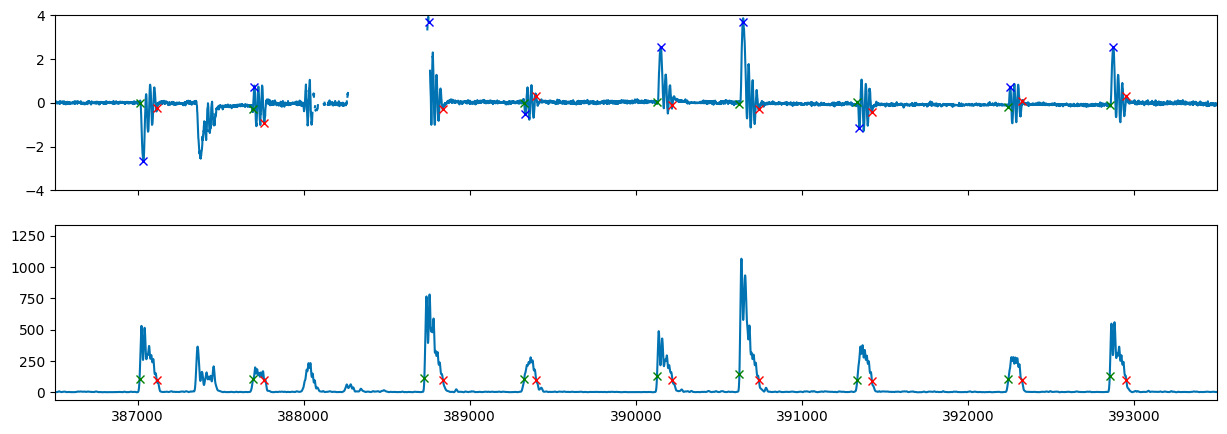

In [21]:
fig,ax = plt.subplots(2,1,figsize=(15,5),sharex=True)

x = tracking_data._tail_angle[:,7]
ax[0].plot(x)
ax[0].plot(segments.onset, x[segments.onset], "x",color='green')
ax[0].plot(segments.offset, x[segments.offset], "x",color='red')
ax[0].plot(segments.HB1, x[segments.HB1], "x",color='blue')
ax[0].set_ylim(-4,4)

x = tail.vigor
ax[1].plot(x)
ax[1].plot(segments.onset, x[segments.onset], "x",color='green')
ax[1].plot(segments.offset, x[segments.offset], "x",color='red')

t = np.arange(tracking_data.T)/tracking_cfg.fps
IdSt = 386502#np.random.randint(tracking_data.T)
Duration = 10*tracking_cfg.fps
ax[1].set_xlim(IdSt,IdSt+Duration)

plt.show()

In [14]:
import matplotlib.gridspec as gridspec

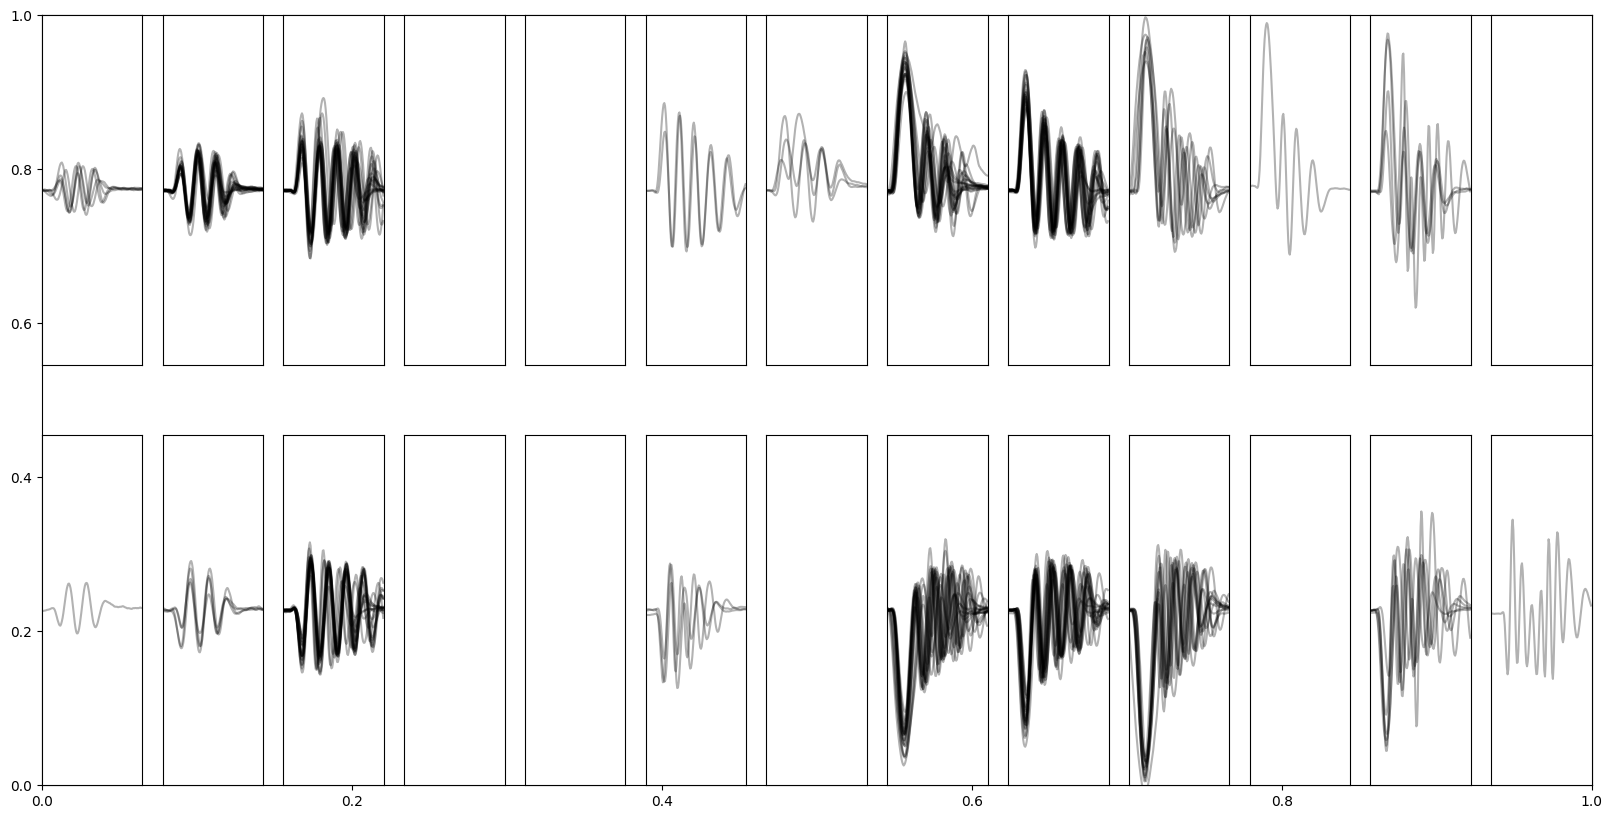

In [17]:
fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 

G = gridspec.GridSpec(2,13)
ax0 = {}
for b in range(13):
    for i_sg,sg in enumerate([1,-1]):        
        ax0 = plt.subplot(G[i_sg,b])
        #ax0.set_title(NameCat[b%11])
        id = bouts.df[(bouts.df.label.category==b) & (bouts.df.label.sign==sg) & (bouts.df.label.proba>0.8)].index
        if len(id)>0:
            id = id[0:20]
            ax0.plot(bouts.tail[id,7,:].T,'k',alpha=.3)
        ax0.set_xlim(0,pipeline.segmentation_cfg.bout_duration)
        ax0.set_ylim(-3.8,3.8)
        ax0.set_xticks([])
        ax0.set_yticks([])
    
plt.show()

In [19]:
from megabouts.utils.utils_plot import NameCatShortSym_w_CS,list_color_w_CS
from megabouts.utils.utils_plot import colorblind_list,lighten_color
import matplotlib as mpl
from cycler import cycler
mpl.rc('axes',**{'prop_cycle':cycler('color',colorblind_list)})
from megabouts.utils.utils_plot import cmp_bouts

num_colors = 8
cb_shades = [lighten_color(colorblind_list[2],x_) for x_ in np.linspace(.2, .9, num_colors)]
cb_cycler = cycler(color=cb_shades)
blue_cycler = cycler(color=plt.cm.Blues(np.linspace(.2, .9, num_colors)))

C:\Users\adrien\AppData\Local\Temp\ipykernel_70944\4195632964.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.imshow(ethogram.df[('bout','cat')].values[IdSt:IdEd].T,cmap=cmp_bouts,aspect='auto',vmin=0,vmax=12,interpolation='nearest',extent=(0,T,0,1))


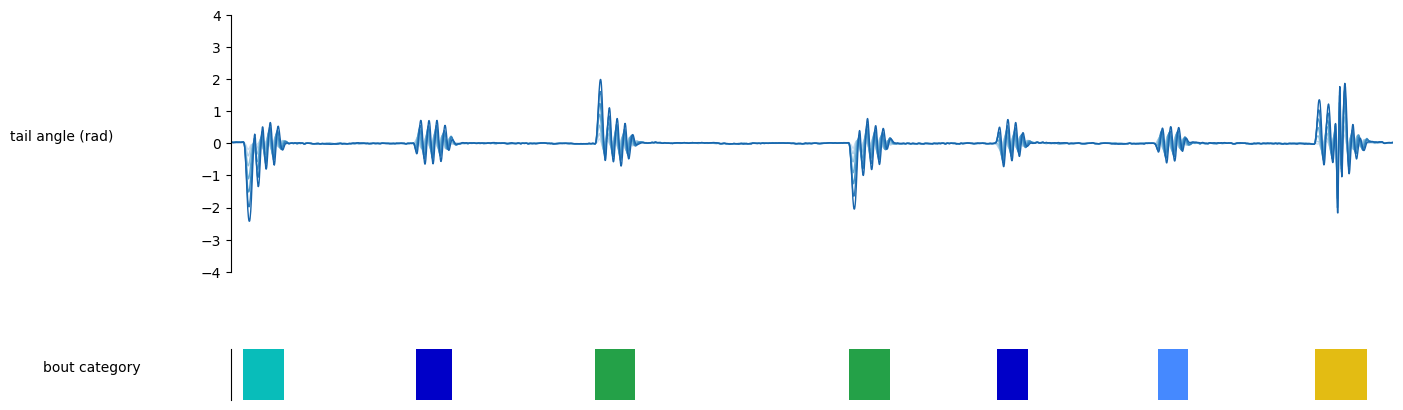

In [30]:
IdSt = 386502#
IdSt = np.random.randint(tracking_data.T)
T = 5
Duration = T*tracking_cfg.fps
IdEd = IdSt+Duration
t = np.arange(Duration)/tracking_cfg.fps


fig = plt.figure(facecolor='white', figsize=(15, 5), constrained_layout=True) 
G = gridspec.GridSpec(2,1,height_ratios=[1,0.2],hspace=.5)
ax = plt.subplot(G[0,0])
ax.set_prop_cycle(blue_cycler)

ax.plot(t,ethogram.df['tail_angle'].values[IdSt:IdEd,:7],lw=1)
ax.set_ylim(-4,4)
ax.set_xlim(0,T)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_yaxis().tick_left()
ax.get_xaxis().set_ticks([])
ax.set_ylabel('tail angle (rad)',rotation=0,labelpad=100)

ax = plt.subplot(G[1,0])
ax.imshow(ethogram.df[('bout','cat')].values[IdSt:IdEd].T,cmap=cmp_bouts,aspect='auto',vmin=0,vmax=12,interpolation='nearest',extent=(0,T,0,1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_yaxis().tick_left()
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_xlim(0,T)

ax.set_ylabel('bout category',rotation=0,labelpad=100)

plt.show()